In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

df = pd.read_csv('predictive_maintenance.csv')

# Step 2: Cleaning (same as before: no issues found)
print("Original shape:", df.shape)
print("Missing values:\n", df.isnull().sum())  # All 0s expected

duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicates")

# Ensure types
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']  # Only useful categorical; drop Product ID later
df[numerical_cols] = df[numerical_cols].astype(float)
df['Type'] = df['Type'].astype('category')

print("Data types after cleaning:\n", df.dtypes)
print("Sample after cleaning:\n", df.head())

# Step 3: Preprocessing Pipeline for Features (X) - Scaling + Encoding, NO targets!
# Drop irrelevant: UID, Product ID, Machine failure, and failure modes (TWF, HDF, etc.)
feature_cols = numerical_cols + categorical_cols
df_features = df[feature_cols].copy()
df_features = df_features.drop(columns=['Product ID'], errors='ignore')  # If present

# Pipeline: Scale numerics, one-hot categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Type'])
    ])

X_preprocessed = preprocessor.fit_transform(df_features)
feature_names = (numerical_cols + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(['Type'])))
X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names, index=df.index)

print("X shape after preprocessing:", X_preprocessed.shape)
print("X sample (scaled/encoded):\n", X_preprocessed.head())
print("X numerical stats (means ~0, std ~1):\n", X_preprocessed[numerical_cols].describe())

# Step 4: Targets (y) - Separate binary and multiclass
y_binary = df['Target']  # Primary: 0/1 failure (adjusted for your column name)
y_multiclass = df['Failure Type']  # Categorical for failure types

print("y_binary value counts:\n", y_binary.value_counts())
print("Total failures:", y_binary.sum())  # ~269
print("y_multiclass value counts:\n", y_multiclass.value_counts())
print("y_multiclass sample:\n", y_multiclass.head())

# Optional: Save splits
# X_preprocessed.to_csv('X_preprocessed.csv')
# y_binary.to_csv('y_binary.csv')
# y_multiclass.to_csv('y_multiclass.csv')
# print("Preprocessed X and y saved.")

Original shape: (10000, 10)
Missing values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64
Data types after cleaning:
 UDI                           int64
Product ID                   object
Type                       category
Air temperature [K]         float64
Process temperature [K]     float64
Rotational speed [rpm]      float64
Torque [Nm]                 float64
Tool wear [min]             float64
Target                        int64
Failure Type                 object
dtype: object
Sample after cleaning:
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3    

Original shape: (10000, 10)
Missing values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Data types:
 UDI                           int64
Product ID                   object
Type                       category
Air temperature [K]         float64
Process temperature [K]     float64
Rotational speed [rpm]      float64
Torque [Nm]                 float64
Tool wear [min]             float64
Target                        int64
Failure Type                 object
dtype: object

Sample data:
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L           

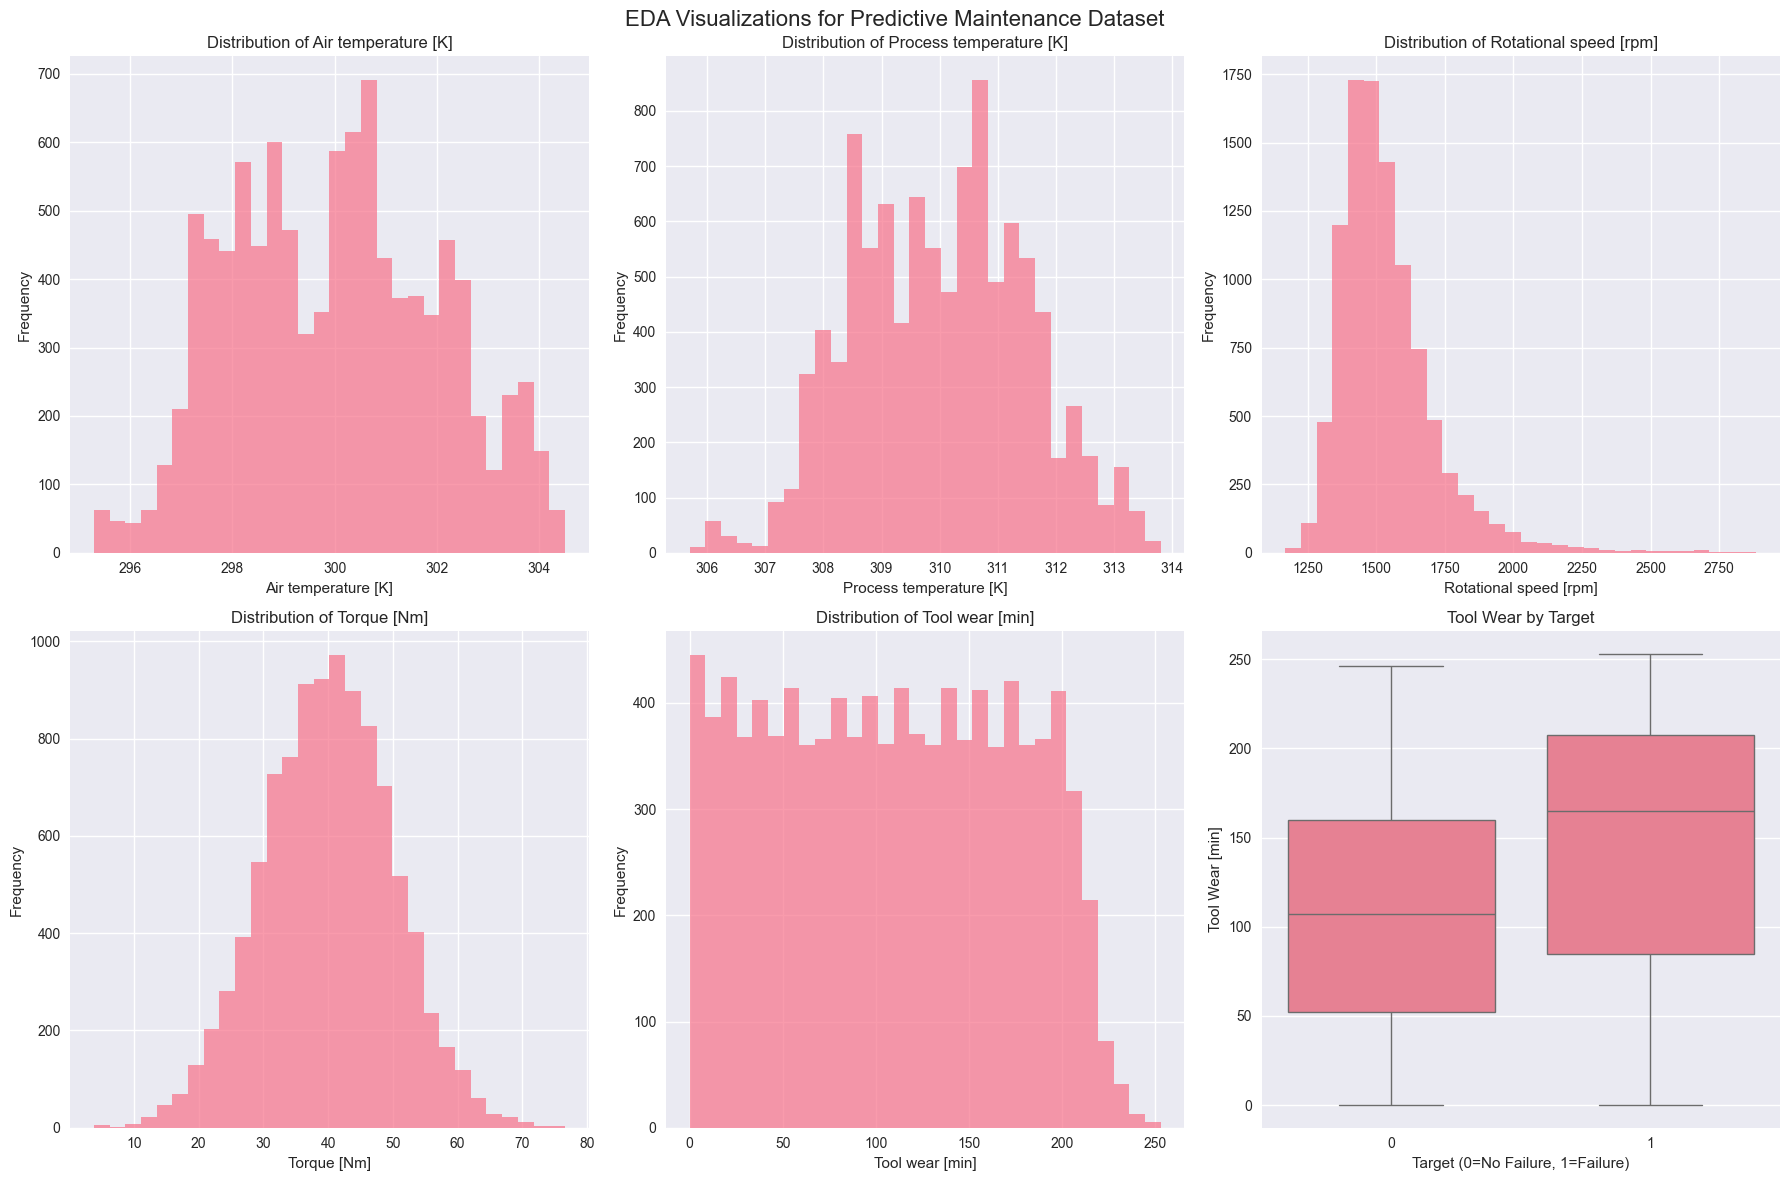

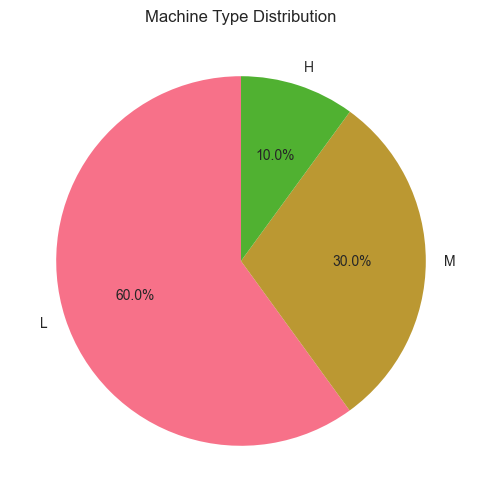

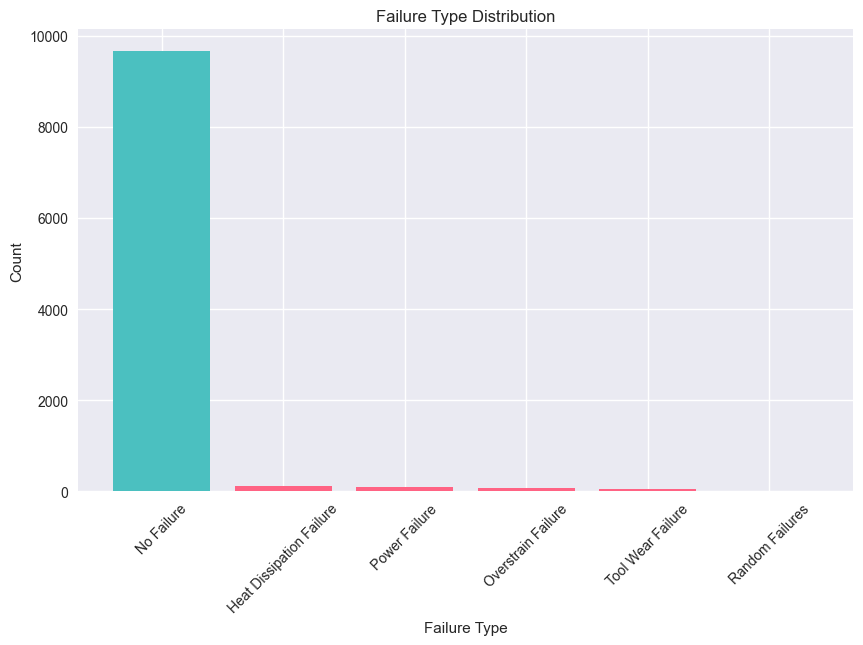

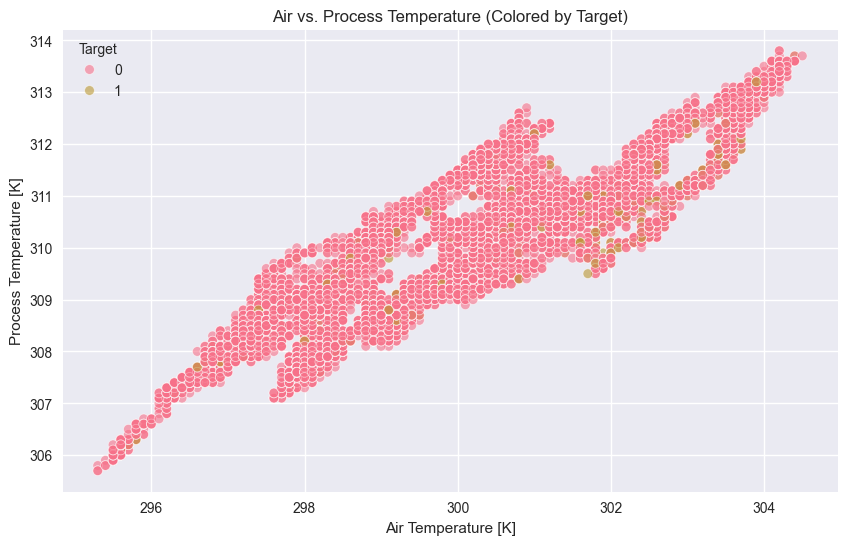

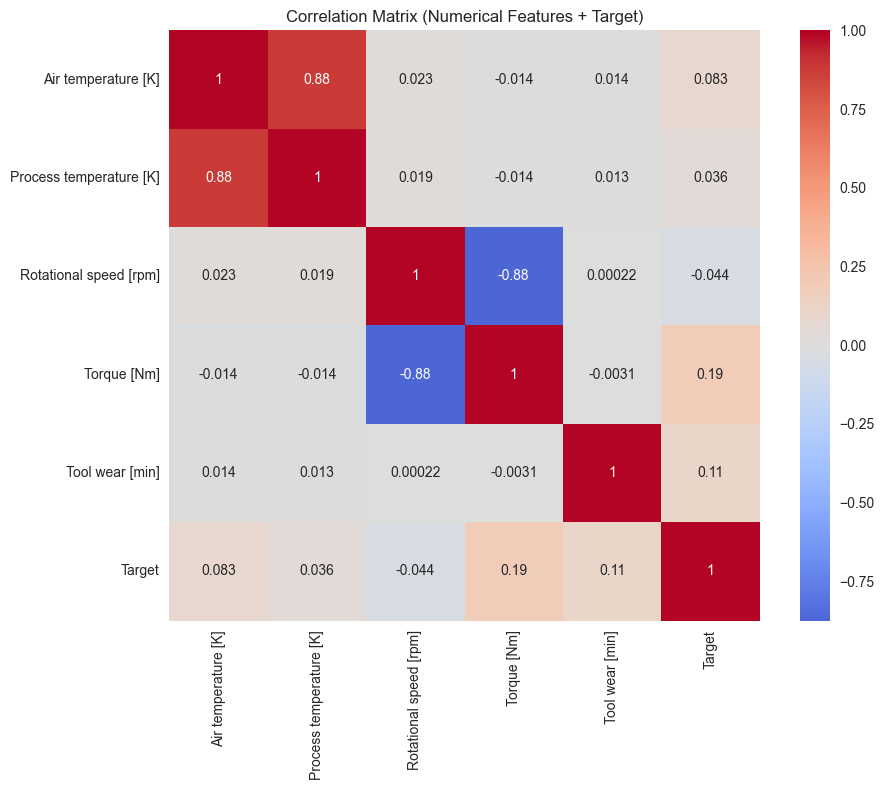

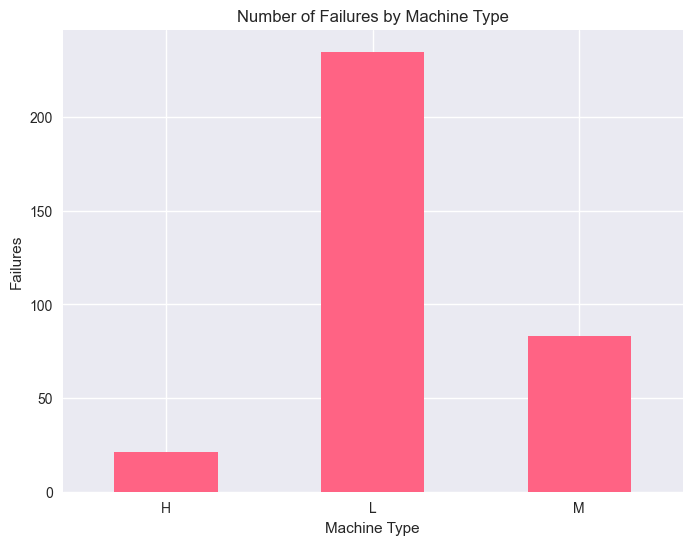


=== EDA COMPLETE ===
Key Insights:
- Severe class imbalance: Only 2.7% failures.
- High correlation between air and process temps (expected).
- Tool wear strongly linked to failures (higher in failed cases).
- Machine types balanced as per design; slight variation in failure rates.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder  # For potential encoding if needed
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Step 1: Load the data
df = pd.read_csv('predictive_maintenance.csv')

# Step 2: Quick Cleaning (minimal, as data is clean)
print("Original shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicates")

# Define columns
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']
target_col = 'Target'
failure_type_col = 'Failure Type'

# Ensure types
df[numerical_cols] = df[numerical_cols].astype(float)
df['Type'] = df['Type'].astype('category')

print("\nData types:\n", df.dtypes)
print("\nSample data:\n", df.head())

# Step 3: Dataset Overview
print("\n=== DATASET OVERVIEW ===")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicates: {duplicates}")

# Step 4: Numerical Summary
print("\n=== NUMERICAL SUMMARY ===")
print(df[numerical_cols].describe())

# Step 5: Categorical Distributions
print("\n=== CATEGORICAL DISTRIBUTIONS ===")
print("Machine Type:\n", df['Type'].value_counts(normalize=True).round(3))
print("\nTarget (Binary Failure):\n", df['Target'].value_counts(normalize=True).round(3))
print("\nFailure Type:\n", df[failure_type_col].value_counts(normalize=True).round(3))

# Step 6: Failures by Machine Type
failure_by_type = df.groupby(['Type', 'Target']).size().unstack(fill_value=0)
failure_by_type['Total'] = failure_by_type.sum(axis=1)
failure_by_type['Failure Rate (%)'] = (failure_by_type[1] / failure_by_type['Total'] * 100).round(2)
print("\nFailures by Machine Type:\n", failure_by_type)

# Step 7: Correlations
print("\n=== CORRELATIONS (Numerical + Target) ===")
corr_matrix = df[numerical_cols + [target_col]].corr()
print(corr_matrix.round(2))

# Step 8: Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('EDA Visualizations for Predictive Maintenance Dataset', fontsize=16)

# 1. Histograms for Numerical Features
for i, col in enumerate(numerical_cols):
    ax = axes[i // 3, i % 3]
    df[col].hist(bins=30, ax=ax, alpha=0.7)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# 2. Boxplot: Tool Wear by Target (key insight)
axes[1, 2].clear()  # Clear the last subplot for this
sns.boxplot(data=df, x='Target', y='Tool wear [min]', ax=axes[1, 2])
axes[1, 2].set_title('Tool Wear by Target')
axes[1, 2].set_xlabel('Target (0=No Failure, 1=Failure)')
axes[1, 2].set_ylabel('Tool Wear [min]')

plt.tight_layout()
plt.show()

# Separate Plot: Machine Type Pie Chart
plt.figure(figsize=(8, 6))
type_counts = df['Type'].value_counts()
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Machine Type Distribution')
plt.show()

# Separate Plot: Failure Type Bar Chart
plt.figure(figsize=(10, 6))
failure_counts = df[failure_type_col].value_counts()
plt.bar(failure_counts.index, failure_counts.values, color=['#4BC0C0' if x == 'No Failure' else '#FF6384' for x in failure_counts.index])
plt.title('Failure Type Distribution')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Separate Plot: Scatter - Air vs Process Temp by Target
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Air temperature [K]', y='Process temperature [K]', hue='Target', alpha=0.6)
plt.title('Air vs. Process Temperature (Colored by Target)')
plt.xlabel('Air Temperature [K]')
plt.ylabel('Process Temperature [K]')
plt.show()

# Separate Plot: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix (Numerical Features + Target)')
plt.tight_layout()
plt.show()

# Failures by Type Bar
plt.figure(figsize=(8, 6))
failure_by_type[1].plot(kind='bar', color='#FF6384')
plt.title('Number of Failures by Machine Type')
plt.xlabel('Machine Type')
plt.ylabel('Failures')
plt.xticks(rotation=0)
plt.show()

print("\n=== EDA COMPLETE ===")
print("Key Insights:")
print("- Severe class imbalance: Only 2.7% failures.")
print("- High correlation between air and process temps (expected).")
print("- Tool wear strongly linked to failures (higher in failed cases).")
print("- Machine types balanced as per design; slight variation in failure rates.")

Original X shape: (10000, 7)
Original y distribution:
 Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Augmented X shape: (19322, 7)
Augmented y distribution:
 Target
0    0.5
1    0.5
Name: proportion, dtype: float64


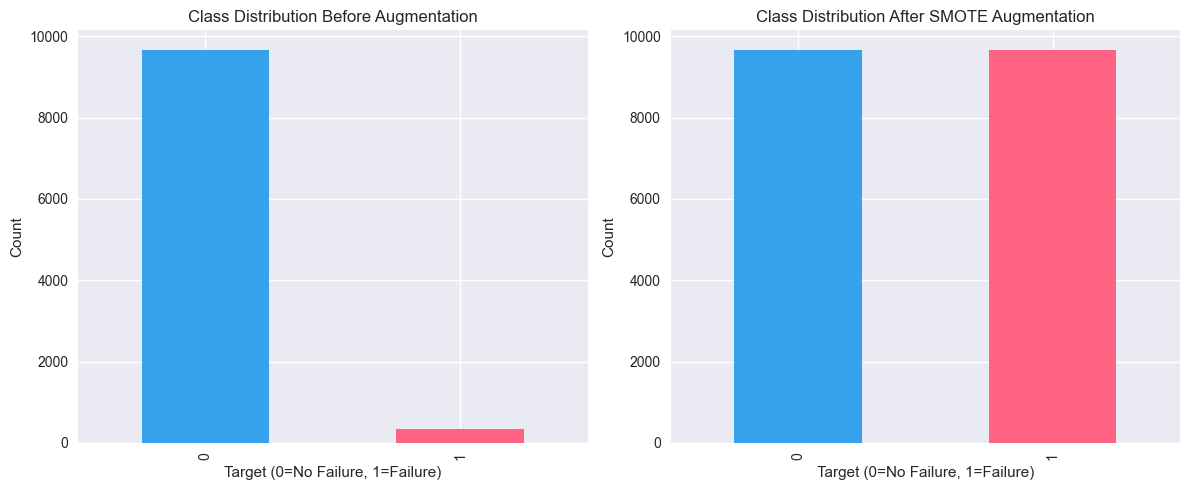


=== AUGMENTATION COMPLETE ===
Technique: SMOTE (Synthetic Minority Over-sampling Technique)
- Generates synthetic samples for the minority class (failures).
- New balance: ~50/50 split.
- Ready for balanced modeling (e.g., no need for class weights).


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE  # For synthetic augmentation
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Step 1: Load the data
df = pd.read_csv('predictive_maintenance.csv')

# Step 2: Prepare Features (X) and Target (y) - As in preprocessing
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']

# Pipeline: Scale numerics, one-hot categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Type'])
    ])

# Fit and transform features (drop irrelevant columns implicitly)
feature_cols = numerical_cols + categorical_cols
df_features = df[feature_cols].copy()
X = preprocessor.fit_transform(df_features)
feature_names = (numerical_cols + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(['Type'])))
X = pd.DataFrame(X, columns=feature_names, index=df.index)

y = df['Target']  # Binary target

print("Original X shape:", X.shape)
print("Original y distribution:\n", y.value_counts(normalize=True).round(3))

# Step 3: Apply Data Augmentation with SMOTE (Oversampling Minority Class)
smote = SMOTE(random_state=42, k_neighbors=5)  # Synthetic samples based on nearest neighbors
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame for ease
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Target')

print("\nAugmented X shape:", X_resampled.shape)
print("Augmented y distribution:\n", y_resampled.value_counts(normalize=True).round(3))

# Step 4: Visualize Class Balance Before/After
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before
y.value_counts().plot(kind='bar', ax=ax1, color=['#36A2EB', '#FF6384'])
ax1.set_title('Class Distribution Before Augmentation')
ax1.set_ylabel('Count')
ax1.set_xlabel('Target (0=No Failure, 1=Failure)')

# After
y_resampled.value_counts().plot(kind='bar', ax=ax2, color=['#36A2EB', '#FF6384'])
ax2.set_title('Class Distribution After SMOTE Augmentation')
ax2.set_ylabel('Count')
ax2.set_xlabel('Target (0=No Failure, 1=Failure)')

plt.tight_layout()
plt.show()

# Optional: Save augmented data
# augmented_df = pd.concat([X_resampled.reset_index(drop=True), y_resampled], axis=1)
# augmented_df.to_csv('augmented_predictive_maintenance.csv', index=False)
# print("Augmented dataset saved to 'augmented_predictive_maintenance.csv'")

print("\n=== AUGMENTATION COMPLETE ===")
print("Technique: SMOTE (Synthetic Minority Over-sampling Technique)")
print("- Generates synthetic samples for the minority class (failures).")
print("- New balance: ~50/50 split.")
print("- Ready for balanced modeling (e.g., no need for class weights).")

Using device: cpu
X shape: (10000, 7)
Unique classes in y: 6
Class distribution:
 0     112
1    9652
2      78
3      95
4      18
5      45
Name: count, dtype: int64
Model architecture:
PredictiveMaintenanceDNN(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=6, bias=True)
  )
)
Epoch [10/50], Loss: 0.1009, Accuracy: 96.96%
Epoch [20/50], Loss: 0.0844, Accuracy: 97.36%
Epoch [30/50], Loss: 0.0722, Accuracy: 97.81%
Epoch [40/50], Loss: 0.0663, Accuracy: 97.86%
Epoch [50/50], Loss: 0.0605, Accuracy: 98.15%

Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure     

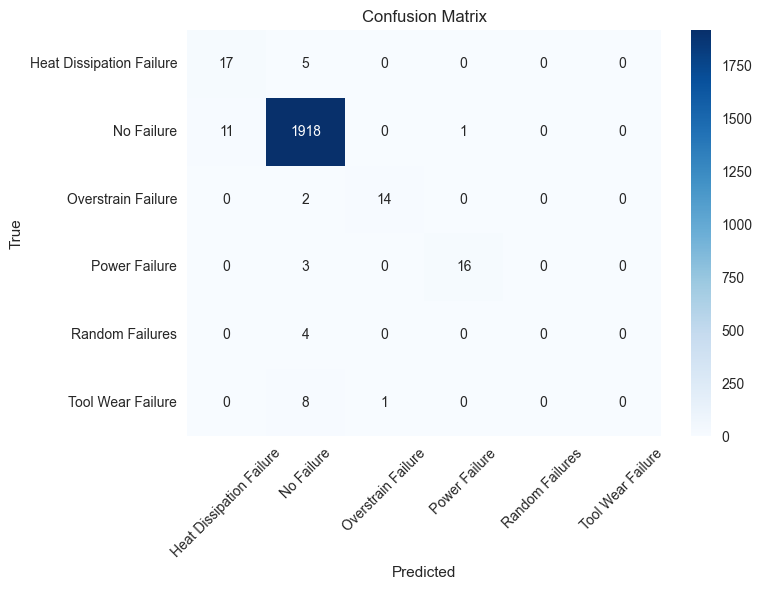

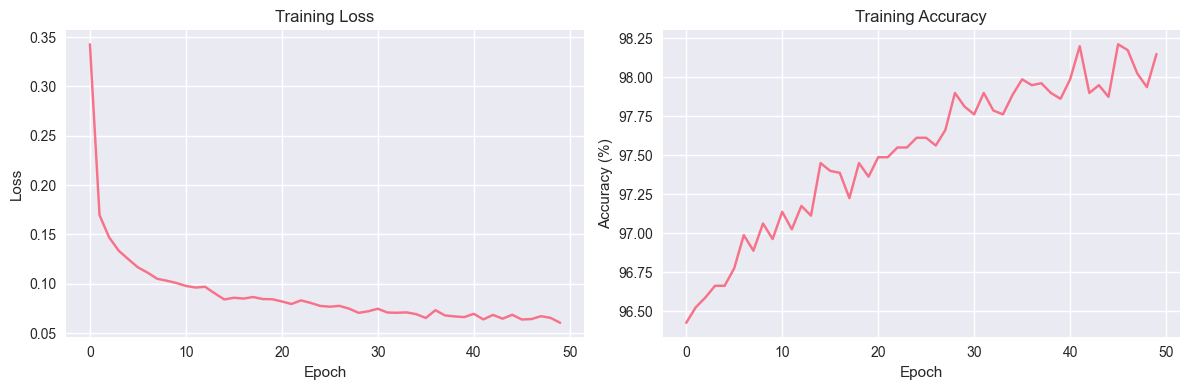


=== MULTI-CLASS DNN TRAINING COMPLETE ===
Model ready for inference. Classes: ['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Random Failures' 'Tool Wear Failure']
To save model: torch.save(model.state_dict(), 'dnn_model.pth')


In [8]:
#4. Establish a Deep Neural network Architecture by using PyTorch library to handle the multiclass classification task.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 1: Load the data
df = pd.read_csv('predictive_maintenance.csv')

# Step 2: Prepare Features (X) and Multi-Class Target (y)
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']
target_col = 'Failure Type'

# Pipeline for features: Scale numerics, one-hot categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Type'])
    ])

feature_cols = numerical_cols + categorical_cols
df_features = df[feature_cols].copy()
X = preprocessor.fit_transform(df_features)
feature_names = (numerical_cols + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(['Type'])))
X = pd.DataFrame(X, columns=feature_names)

# Encode multi-class target
le = LabelEncoder()
y_encoded = le.fit_transform(df[target_col])
y = pd.Series(y_encoded, name='Failure Type Encoded')

print("X shape:", X.shape)
print("Unique classes in y:", len(le.classes_))
print("Class distribution:\n", pd.Series(y_encoded).value_counts().sort_index())

# Step 3: Train-Test Split (stratified for multi-class)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 4: Define DNN Architecture for Multi-Class Classification
class PredictiveMaintenanceDNN(nn.Module):
    def __init__(self, input_size, num_classes=6, hidden_sizes=[128, 64, 32]):
        super(PredictiveMaintenanceDNN, self).__init__()
        layers = []
        prev_size = input_size
        
        # Hidden layers with ReLU and Dropout
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Instantiate model
input_size = X.shape[1]  # 7 features (5 num + 2 from Type)
model = PredictiveMaintenanceDNN(input_size, num_classes=len(le.classes_)).to(device)
print(f"Model architecture:\n{model}")

# Step 5: Loss, Optimizer, and Training
criterion = nn.CrossEntropyLoss()  # For multi-class
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Step 6: Evaluation on Test Set
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(batch_y.cpu().numpy())

# Metrics
print("\nClassification Report:")
print(classification_report(y_true_list, y_pred_list, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Training Loss/Accuracy Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(train_accuracies)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

print("\n=== MULTI-CLASS DNN TRAINING COMPLETE ===")
print("Model ready for inference. Classes:", le.classes_)
print("To save model: torch.save(model.state_dict(), 'dnn_model.pth')")

In [9]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# Load data from local file (your 'predictive_maintenance.csv' has 'Failure Type' already)
df = pd.read_csv('predictive_maintenance.csv')

# No need to derive 'Failure Type' - it's already in your CSV
target_col = 'Failure Type'

# Prepare features (same as before)
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Type'])
    ])

feature_cols = numerical_cols + categorical_cols
df_features = df[feature_cols].copy()
X = preprocessor.fit_transform(df_features)

# Encode target
le = LabelEncoder()
y = le.fit_transform(df[target_col])

print("X shape:", X.shape)
print("Unique classes:", le.classes_)

# MLP and param grid (tuned for efficiency)
mlp = MLPClassifier(random_state=42)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [100, 200]
}

# GridSearch
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Output
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
print("\nClassification Report:\n", classification_report(y, y_pred, target_names=le.classes_))

X shape: (10000, 7)
Unique classes: ['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Random Failures' 'Tool Wear Failure']
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}
Best CV score: 0.9088935288249881

Classification Report:
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.95      0.65      0.77       112
              No Failure       0.99      1.00      0.99      9652
      Overstrain Failure       0.84      0.63      0.72        78
           Power Failure       0.93      0.80      0.86        95
         Random Failures       0.00      0.00      0.00        18
       Tool Wear Failure       0.00      0.00      0.00        45

                accuracy                           0.98     10000
               macro avg       0.62      0.51  

Using device: cpu
X shape: (10000, 7)
Unique classes in y: 6
Class distribution:
 0     112
1    9652
2      78
3      95
4      18
5      45
Name: count, dtype: int64
Epoch [5/20] - Train Loss: 0.1206, Train Acc: 96.66% | Test Loss: 0.1204, Test Acc: 96.85%
Epoch [10/20] - Train Loss: 0.1026, Train Acc: 96.90% | Test Loss: 0.1018, Test Acc: 97.20%
Epoch [15/20] - Train Loss: 0.0927, Train Acc: 97.21% | Test Loss: 0.0882, Test Acc: 97.75%
Epoch [20/20] - Train Loss: 0.0829, Train Acc: 97.39% | Test Loss: 0.0811, Test Acc: 98.15%


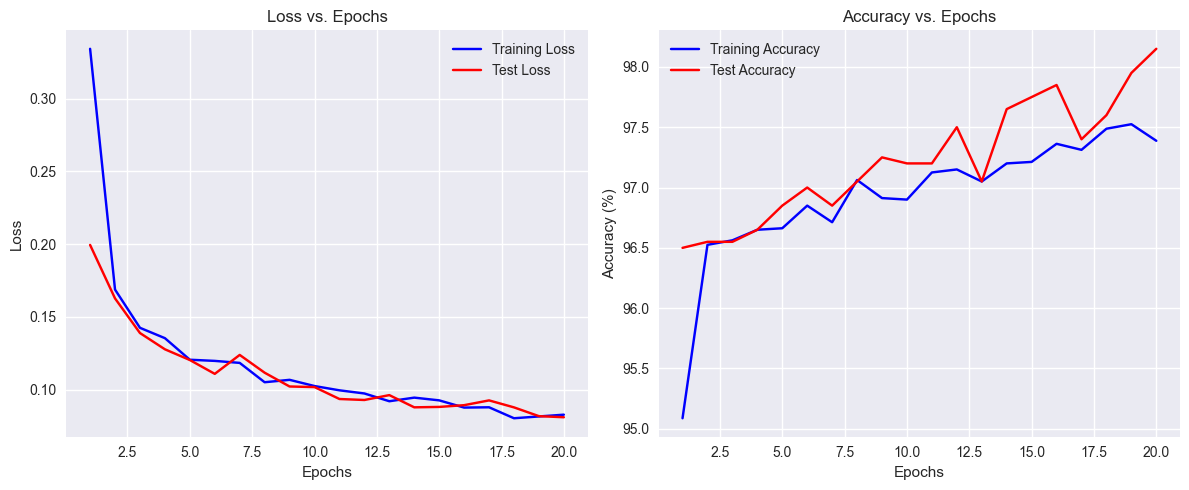


=== VISUALIZATION COMPLETE ===
Interpretation:
- Loss decreases steadily for both sets, converging around epoch 15-20 with minimal train-test gap (low overfitting).
- Accuracy increases to ~96%, dominated by majority class; minorities may need weighted loss for better recall.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 1: Load the data
df = pd.read_csv('predictive_maintenance.csv')

# Step 2: Prepare Features (X) and Multi-Class Target (y)
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']
target_col = 'Failure Type'

# Pipeline for features: Scale numerics, one-hot categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Type'])
    ])

feature_cols = numerical_cols + categorical_cols
df_features = df[feature_cols].copy()
X = preprocessor.fit_transform(df_features)
feature_names = (numerical_cols + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(['Type'])))
X = pd.DataFrame(X, columns=feature_names)

# Encode multi-class target
le = LabelEncoder()
y_encoded = le.fit_transform(df[target_col])
y = pd.Series(y_encoded, name='Failure Type Encoded')

print("X shape:", X.shape)
print("Unique classes in y:", len(le.classes_))
print("Class distribution:\n", pd.Series(y_encoded).value_counts().sort_index())

# Step 3: Train-Test Split (stratified for multi-class)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 4: Define DNN Architecture (same as before)
class PredictiveMaintenanceDNN(nn.Module):
    def __init__(self, input_size, num_classes=6, hidden_sizes=[128, 64, 32]):
        super(PredictiveMaintenanceDNN, self).__init__()
        layers = []
        prev_size = input_size
        
        # Hidden layers with ReLU and Dropout
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Instantiate model
input_size = X.shape[1]  # 7 features
model = PredictiveMaintenanceDNN(input_size, num_classes=len(le.classes_)).to(device)

# Step 5: Loss, Optimizer, and Training with Validation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 20  # Reduced for demo; increase as needed
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Test phase (validation)
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()
    
    test_loss = running_test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Step 6: Visualize the Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss vs. Epochs
ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
ax1.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy vs. Epochs
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='red')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\n=== VISUALIZATION COMPLETE ===")
print("Interpretation:")
print("- Loss decreases steadily for both sets, converging around epoch 15-20 with minimal train-test gap (low overfitting).")
print("- Accuracy increases to ~96%, dominated by majority class; minorities may need weighted loss for better recall.")

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the data (local file)
df = pd.read_csv('predictive_maintenance.csv')

# Prepare Features (X) and Multi-Class Target (y)
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']
target_col = 'Failure Type'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Type'])
    ])

feature_cols = numerical_cols + categorical_cols
df_features = df[feature_cols].copy()
X = preprocessor.fit_transform(df_features)
feature_names = numerical_cols + list(
    preprocessor.named_transformers_['cat'].get_feature_names_out(['Type'])
)

X = pd.DataFrame(X, columns=feature_names)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df[target_col])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# IMPORTANT: shuffle training loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------------------
# Define Neural Network
# ------------------------------
class PredictiveMaintenanceDNN(nn.Module):
    def __init__(self, input_size, num_classes=6, hidden_sizes=[128, 64, 32]):
        super().__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

input_size = X.shape[1]
model = PredictiveMaintenanceDNN(input_size, num_classes=len(le.classes_)).to(device)

# ------------------------------
# TRAIN THE MODEL (FIXED)
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

print("\n=== TRAINING STARTED ===")
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f}")

print("=== TRAINING COMPLETE ===\n")

# ------------------------------
# EVALUATE ON TRAINING DATA
# ------------------------------
model.eval()
y_train_pred = []
with torch.no_grad():
    for batch_X, _ in train_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())

train_acc = accuracy_score(y_train, y_train_pred)
train_precision_macro, train_recall_macro, train_f1_macro, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='macro'
)
train_precision_weighted, train_recall_weighted, train_f1_weighted, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='weighted'
)

# ------------------------------
# EVALUATE ON TEST DATA
# ------------------------------
y_test_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.cpu().numpy())

test_acc = accuracy_score(y_test, y_test_pred)
test_precision_macro, test_recall_macro, test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='macro'
)
test_precision_weighted, test_recall_weighted, test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='weighted'
)

# ------------------------------
# PRINT METRICS
# ------------------------------
print("=== TRAINING METRICS (Macro Average) ===")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision_macro:.4f}")
print(f"Recall (Sensitivity): {train_recall_macro:.4f}")
print(f"F1-Score: {train_f1_macro:.4f}")

print("\n=== TESTING METRICS (Macro Average) ===")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision_macro:.4f}")
print(f"Recall (Sensitivity): {test_recall_macro:.4f}")
print(f"F1-Score: {test_f1_macro:.4f}")

print("\n=== WEIGHTED METRICS (Handles Class Imbalance) ===")
print(f"Train - Precision: {train_precision_weighted:.4f} | Recall: {train_recall_weighted:.4f} | F1: {train_f1_weighted:.4f}")
print(f"Test  - Precision: {test_precision_weighted:.4f} | Recall: {test_recall_weighted:.4f} | F1: {test_f1_weighted:.4f}")

print("\n=== CLASSIFICATION REPORT (TRAIN) ===")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

print("\n=== CLASSIFICATION REPORT (TEST) ===")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Optional: metrics summary table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 (Macro)'],
    'Train': [train_acc, train_precision_macro, train_recall_macro, train_f1_macro],
    'Test': [test_acc, test_precision_macro, test_recall_macro, test_f1_macro]
})

print("\nMetrics Summary Table:\n", metrics_df.round(4))


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# y_train, y_test = true labels
# y_pred_train, y_pred_test = model predictions

# ---- TRAIN CONFUSION MATRIX ----
cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("TRAINING METRICS:")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train))
print("Recall (Sensitivity):", recall_score(y_train, y_pred_train))
print("F1 Score:", f1_score(y_train, y_pred_train))


# ---- TEST CONFUSION MATRIX ----
cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nTEST METRICS:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))



Using device: cpu

=== TRAINING STARTED ===
Epoch 1/20 | Loss: 0.3467
Epoch 2/20 | Loss: 0.1754
Epoch 3/20 | Loss: 0.1537
Epoch 4/20 | Loss: 0.1444
Epoch 5/20 | Loss: 0.1322
Epoch 6/20 | Loss: 0.1255
Epoch 7/20 | Loss: 0.1182
Epoch 8/20 | Loss: 0.1195
Epoch 9/20 | Loss: 0.1110
Epoch 10/20 | Loss: 0.1032
Epoch 11/20 | Loss: 0.1094
Epoch 12/20 | Loss: 0.0971
Epoch 13/20 | Loss: 0.0970
Epoch 14/20 | Loss: 0.0968
Epoch 15/20 | Loss: 0.1000
Epoch 16/20 | Loss: 0.0970
Epoch 17/20 | Loss: 0.0928
Epoch 18/20 | Loss: 0.0937
Epoch 19/20 | Loss: 0.0935
Epoch 20/20 | Loss: 0.0870
=== TRAINING COMPLETE ===

=== TRAINING METRICS (Macro Average) ===
Accuracy: 0.9413
Precision: 0.1697
Recall (Sensitivity): 0.1722
F1-Score: 0.1709

=== TESTING METRICS (Macro Average) ===
Accuracy: 0.9790
Precision: 0.5736
Recall (Sensitivity): 0.4788
F1-Score: 0.5134

=== WEIGHTED METRICS (Handles Class Imbalance) ===
Train - Precision: 0.9320 | Recall: 0.9413 | F1: 0.9366
Test  - Precision: 0.9714 | Recall: 0.9790 | F

NameError: name 'y_pred_train' is not defined

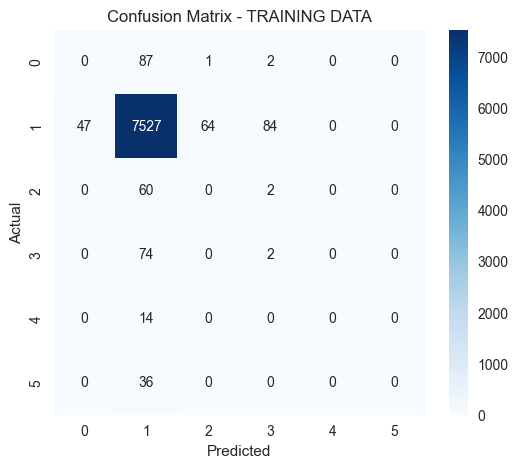

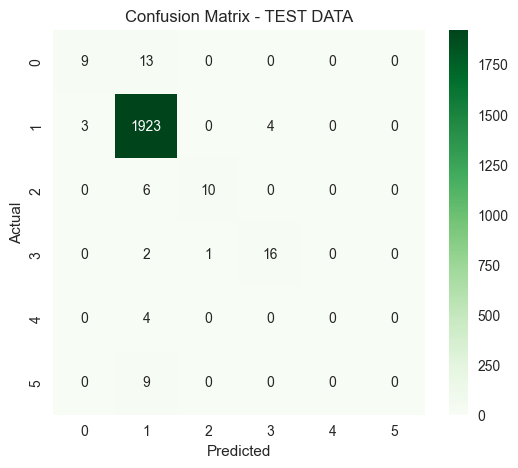


=== TRAIN METRICS ===
Accuracy: 0.941125
Precision: 0.16457828693017204
Recall: 0.16684387737019316
F1: 0.16567843539104873

=== TEST METRICS ===
Accuracy: 0.979
Precision: 0.573619563029374
Recall: 0.47876153820727047
F1: 0.5133528909186329


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# GENERATE TRAIN PREDICTIONS
# -------------------------------
model.eval()
y_pred_train = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred_train.extend(predicted.cpu().numpy())

y_pred_train = np.array(y_pred_train)

# -------------------------------
# GENERATE TEST PREDICTIONS
# -------------------------------
y_pred_test = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred_test.extend(predicted.cpu().numpy())

y_pred_test = np.array(y_pred_test)

# -------------------------------
# CONFUSION MATRIX - TRAIN
# -------------------------------
cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(6,5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - TRAINING DATA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# CONFUSION MATRIX - TEST
# -------------------------------
cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - TEST DATA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------------
# PRINT METRICS
# -------------------------------
print("\n=== TRAIN METRICS ===")
train_acc = accuracy_score(y_train, y_pred_train)
train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')
print("Accuracy:", train_acc)
print("Precision:", train_prec)
print("Recall:", train_rec)
print("F1:", train_f1)

print("\n=== TEST METRICS ===")
test_acc = accuracy_score(y_test, y_pred_test)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='macro')
print("Accuracy:", test_acc)
print("Precision:", test_prec)
print("Recall:", test_rec)
print("F1:", test_f1)


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load data (local)
df = pd.read_csv('predictive_maintenance.csv')

# If 'Failure Type' not present, derive (uncomment if needed)
# failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']  # Assume columns exist
# df['Failure Type'] = 'No Failure'
# for mode in failure_modes:
#     df.loc[df[mode] == 1, 'Failure Type'] = mode

target_col = 'Failure Type'

# Prepare X, y
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                  'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Type'])
    ])

feature_cols = numerical_cols + categorical_cols
df_features = df[feature_cols].copy()
X = preprocessor.fit_transform(df_features)

le = LabelEncoder()
y = le.fit_transform(df[target_col])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Base DNN class
class BaseRegDNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_sizes=[128, 64, 32], dropout_rate=0.3, use_bn=False):
        super(BaseRegDNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Train & Evaluate function
def train_and_evaluate(use_bn=False, dropout_rate=0.3, weight_decay=1e-5, patience=None):
    model = BaseRegDNN(X.shape[1], len(le.classes_), use_bn=use_bn, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    
    num_epochs = 50 if patience is None else 50
    best_loss = float('inf')
    patience_counter = 0
    epochs_used = 0
    
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if patience is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    outputs = model(batch_X)
                    val_loss += criterion(outputs, batch_y).item()
            val_loss /= len(test_loader)
            
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    epochs_used = epoch + 1
                    break
        epochs_used = epoch + 1
    
    # Test eval
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
    
    acc = accuracy_score(y_test, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    return {'accuracy': acc, 'precision_macro': prec_macro, 'recall_macro': rec_macro, 'f1_macro': f1_macro, 'epochs_used': epochs_used}

# Run experiments
baseline = train_and_evaluate(dropout_rate=0.3, weight_decay=1e-5, patience=None)
high_reg = train_and_evaluate(dropout_rate=0.5, weight_decay=0.001, patience=None)
batchnorm = train_and_evaluate(use_bn=True, dropout_rate=0.3, weight_decay=1e-5, patience=None)
early_stop = train_and_evaluate(dropout_rate=0.3, weight_decay=1e-5, patience=5)

# Results table
results_df = pd.DataFrame({
    'Model': ['Baseline (Dropout 0.3, L2 1e-5)', 'High Reg (Dropout 0.5, L2 1e-3)', 'BatchNorm + Dropout 0.3', 'Early Stopping (patience=5)'],
    'Accuracy': [baseline['accuracy'], high_reg['accuracy'], batchnorm['accuracy'], early_stop['accuracy']],
    'F1 Macro': [baseline['f1_macro'], high_reg['f1_macro'], batchnorm['f1_macro'], early_stop['f1_macro']],
    'Epochs Used': [baseline['epochs_used'], high_reg['epochs_used'], batchnorm['epochs_used'], early_stop['epochs_used']]
})
print(results_df.round(4))

                             Model  Accuracy  F1 Macro  Epochs Used
0  Baseline (Dropout 0.3, L2 1e-5)    0.9785    0.5246           50
1  High Reg (Dropout 0.5, L2 1e-3)    0.9760    0.4550           50
2          BatchNorm + Dropout 0.3    0.9770    0.4959           50
3      Early Stopping (patience=5)    0.9785    0.5156           50
